In [2]:
import numpy as np
print('numpy: '+np.version.full_version)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib
print('matplotlib: '+matplotlib.__version__)

numpy: 1.20.3
matplotlib: 3.5.0


In [3]:
N = 150 # Meshsize
fps = 10 # frame per sec
frn = 50 # frame number of the animation

x = np.linspace(-4,4,N+1)
x, y = np.meshgrid(x, x)
zarray = np.zeros((N+1, N+1, frn))

f = lambda x,y,sig : 1/np.sqrt(sig)*np.exp(-(x**2+y**2)/sig**2)

for i in range(frn):
    zarray[:,:,i] = f(x,y,1.5+np.sin(i*2*np.pi/frn))

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


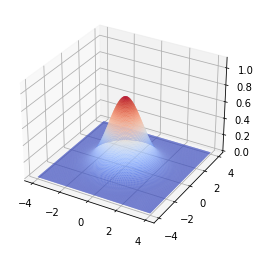

In [4]:
def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(x, y, zarray[:,:,frame_number], cmap="magma")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(x, y, zarray[:,:,0], cmap=plt.cm.coolwarm, rstride=1, cstride=1)]
ax.set_zlim(0,1.1)
ani = animation.FuncAnimation(fig, update_plot, frn, fargs=(zarray, plot), interval=1000)

plt.show()

In [4]:
# fn = 'plot_surface_animation_funcanimation'
# ani.save(fn+'.mp4',writer='ffmpeg',fps=fps)
# ani.save(fn+'.gif',writer='imagemagick',fps=fps)

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


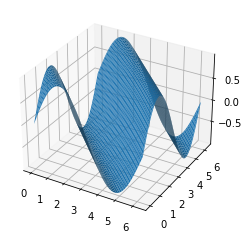

In [5]:
from mpl_toolkits.mplot3d import Axes3D

def data(i,z,line):
    z = np.sin(x+y+i)
    ax.clear()
    line = ax.plot_surface(x,y,z)
    return line,

n = 2.*np.pi
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0,n,100)
y = np.linspace(0,n,100)

x,y = np.meshgrid(x, y)

z = np.sin(x+y)

line = ax.plot_surface(x,y,z)

ani = animation.FuncAnimation(fig, data, fargs=(z, line), interval=30, blit=False)

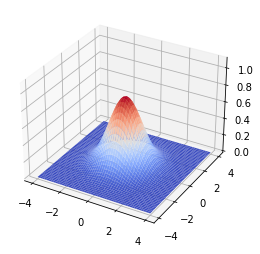

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

N = 50
fps = 250
frn = 75

x = np.linspace(-4, 4, N + 1)
x, y = np.meshgrid(x, x)
zarray = np.zeros((N + 1, N + 1, frn))

f = lambda x, y, sig: 1 / np.sqrt(sig) * np.exp(-(x ** 2 + y ** 2) / sig ** 2)

for i in range(frn):
    zarray[:, :, i] = f(x, y, 1.5 + np.sin(i * 2 * np.pi / frn))

def change_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(x, y, zarray[:, :, frame_number], cmap=plt.cm.coolwarm)
    return plot,
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(x, y, zarray[:, :, 0], cmap=plt.cm.coolwarm,rstride=1, cstride=1)]

ax.set_zlim(0, 1.1)
ani = animation.FuncAnimation(fig, change_plot, frn, fargs=(zarray, plot), interval=1000 / fps)

#ax.axis('off')

plt.show()

In [ ]:
def apply_ice_bc_new(Mmatrix_inv,qT,qS,hT, c1, bcst1,hB, c2,SB, bcst2,intma,jac_side,imapl,psideh,Np,N,Q,Nside,dt,\
                     gammaS,gammaT, cw, Li, ci, Ti, b, c, pb, a, Kf, Mf, coefF,Meltrate,SaltB, vType):
    
    B = zeros(Np)
    bol = False

    for n in range(Nside):
        
        el = int(psideh[n,2])
        iloc = int(psideh[n,0])
        er = int(psideh[n,3])
        
        flag = 0
        
        if(er < 0):
            
            flag = er%-10
        
        if(flag == -7):
            #print("Neumann ",flag)
            bol = True
            
            for i in range(Q+1):

                wq = jac_side[n,i]
                
                il = int(imapl[i,iloc,0])
                jl = int(imapl[i,iloc,1])
                ip = int(intma[el,il,jl])
                
                ip1 = int(intma[el+1,il,jl])
                
                print(ip,ip1)
                
                Tw = qT[ip1]
                Sw = qS[ip1]

                L = coefF(Tw, gammaS,gammaT, cw, Li, ci, Ti, b, c, pb, a, Sw)
                # compute salinity at the boundary
                SB = SaltB(Kf,L,Mf,Sw)
                #print(SB)
                # Compute melt rate
                V = Meltrate(Sw, SB, gammaS)
                #print(V)
                if(vType == "heat"):
                    ndp = hT(bcst1, V)
                if(vType == "salt"):
                    ndp = hB(bcst2,SB, V)
                    
                #ndp = nxl*ndp + nyl*ndp
                    
                B[ip] -= wq*ndp
    
    if(bol and vType == "heat"):
        
        B1 = Mmatrix_inv@B
        q = qT + dt*B1
        
    elif(bol and vType == "salt"):
        
        B1 = Mmatrix_inv@B
        q = qS + dt*B1
    
    return q